# all feature to be selected

In [6]:
import numpy as np
import pandas as pd

df_features = pd.read_parquet("data/features_d002.parquet")
df_label = pd.read_parquet("data/label_d002.parquet")
print(df_label.shape)
df_label.head()

(891360, 5)


,close,ret,trgt,bin,side
index,,,,,
2020-01-01 00:00:00+00:00,7177.93,NaN,NaN,0.0,0.0
2020-01-01 00:03:00+00:00,7175.61,NaN,NaN,0.0,0.0
2020-01-01 00:06:00+00:00,7182.06,NaN,NaN,0.0,0.0
2020-01-01 00:09:00+00:00,7183.07,NaN,NaN,0.0,0.0
2020-01-01 00:12:00+00:00,7176.26,NaN,NaN,0.0,0.0


In [7]:
meta_mask = df_label["ret"].notna().tolist()
side_mask = (df_label["side"].astype(int) != 0).tolist()

meta_label = df_label[meta_mask]["bin"].astype(np.int8).reset_index(drop=True)
meta_label.name = "label"
side_label = (
    (df_label[side_mask]["side"].astype(int) == 1)
    .astype(np.int8)
    .reset_index(drop=True)
)
side_label.name = "label"

meta_features = df_features[meta_mask].reset_index(drop=True)
side_features = df_features[side_mask].reset_index(drop=True)

assert meta_features.shape[0] == meta_label.shape[0]
assert side_features.shape[0] == side_label.shape[0]

# invalid_len = 300
# meta_features = meta_features.iloc[invalid_len:]
# meta_label = meta_label.iloc[invalid_len:]
# side_features = side_features.iloc[invalid_len:]
# side_label = side_label.iloc[invalid_len:]

# meta_split = int(meta_features.shape[0] * 0.8)
# side_split = int(side_features.shape[0] * 0.8)

# meta_x_train = meta_features.iloc[:meta_split]
# meta_x_test = meta_features.iloc[meta_split:]
# meta_y_train = meta_label.iloc[:meta_split]
# meta_y_test = meta_label.iloc[meta_split:]

# assert meta_x_train.shape[0] == meta_y_train.shape[0]
# assert meta_x_test.shape[0] == meta_y_test.shape[0]

# side_x_train = side_features.iloc[:side_split]
# side_x_test = side_features.iloc[side_split:]
# side_y_train = side_label.iloc[:side_split]
# side_y_test = side_label.iloc[side_split:]

# assert side_x_train.shape[0] == side_y_train.shape[0]
# assert side_x_test.shape[0] == side_y_test.shape[0]

In [8]:
meta_label.value_counts()

label
1    348320
0    319741
Name: count, dtype: int64

In [9]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

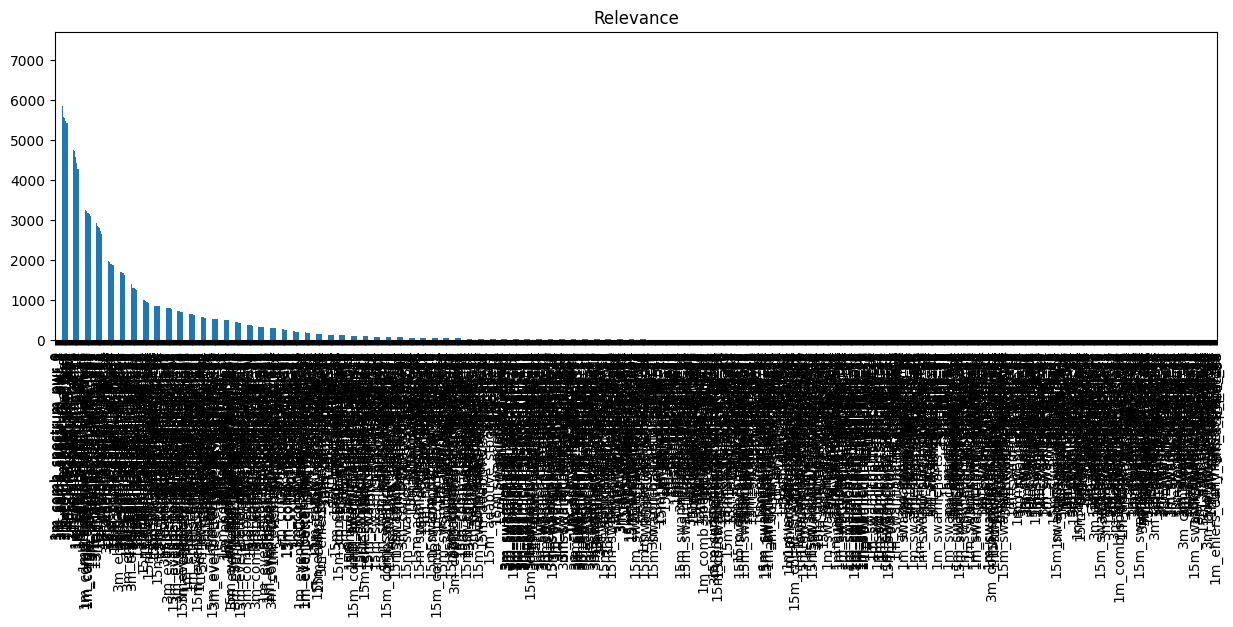

In [10]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [11]:
res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
res

1m_comb_spectrum_pwr_0             7342.824436
1m_comb_spectrum_pwr_1             7045.969754
3m_comb_spectrum_pwr_0             6884.409436
1m_comb_spectrum_pwr_2             6758.669150
1m_comb_spectrum_pwr_3             6607.216895
                                      ...     
1m_ac_35                              0.001271
1m_highpass_bp_lag3                   0.001035
1m_ehlers_early_onset_trend_ddt       0.001019
1m_acp_pwr_29                         0.000031
1m_ac_28                              0.000012
Length: 1263, dtype: float64

In [12]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(res.to_dict(), f)

In [13]:
# side feature selection
side_sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
side_sel.fit(side_features, side_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

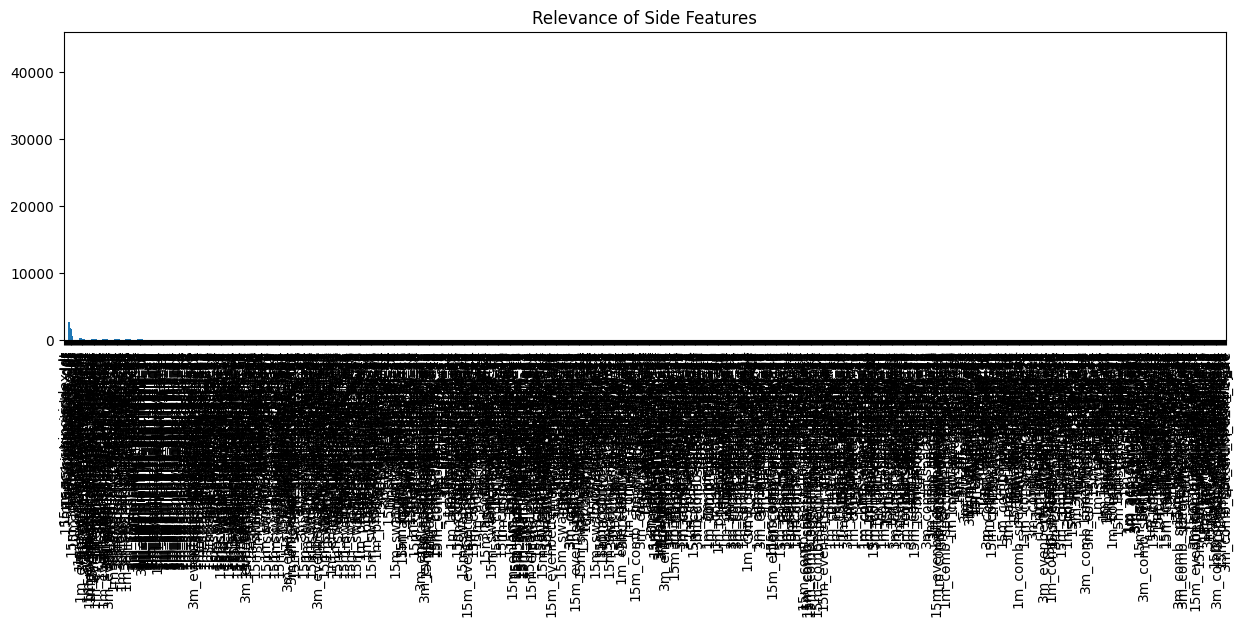

In [14]:
import matplotlib.pyplot as plt

pd.Series(side_sel.relevance_, index=side_sel.variables_).sort_values(
    ascending=False
).plot.bar(figsize=(15, 4))
plt.title("Relevance of Side Features")
plt.show()

In [15]:
side_res = pd.Series(side_sel.relevance_, index=side_sel.variables_).sort_values(
    ascending=False
)
side_res

15m_acc_swing_index_dt        43791.613727
15m_acc_swing_index_ddt       27099.649190
15m_bandpass_ddt               8870.495640
15m_highpass_bp_ddt            8347.872654
15m_roofing_filter_ddt         3873.419209
                                  ...     
3m_homodyne_dt                    0.000101
1m_conv_29                        0.000048
1m_swamicharts_rsi_36             0.000025
3m_dft_spectrum_16                0.000004
3m_comb_spectrum_dom_cycle        0.000001
Length: 1263, dtype: float64

In [16]:
import json

with open("data/mrmr_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f)

# build meta and side features

In [1]:
import json

with open("data/mrmr_meta_features.json") as f:
    meta_features_res = json.load(f)

with open("data/mrmr_side_features.json") as f:
    side_features_res = json.load(f)

meta_features = [k for k, v in meta_features_res.items() if v > 10]
side_features = [k for k, v in side_features_res.items() if v > 10]
all_features = sorted(list(set(meta_features + side_features)))

res = {
    "all": {
        "1m": [],
        "3m": [],
        "15m": [],
    },
    "meta": {
        "1m": [],
        "3m": [],
        "15m": [],
    },
    "side": {
        "1m": [],
        "3m": [],
        "15m": [],
    },
}

for i in all_features:
    if i.startswith("1m_"):
        res["all"]["1m"].append(i.replace("1m_", ""))
    elif i.startswith("3m_"):
        res["all"]["3m"].append(i.replace("3m_", ""))
    elif i.startswith("15m_"):
        res["all"]["15m"].append(i.replace("15m_", ""))

for i in meta_features:
    if i.startswith("1m_"):
        res["meta"]["1m"].append(i)
    elif i.startswith("3m_"):
        res["meta"]["3m"].append(i)
    elif i.startswith("15m_"):
        res["meta"]["15m"].append(i)

for i in side_features:
    if i.startswith("1m_"):
        res["side"]["1m"].append(i)
    elif i.startswith("3m_"):
        res["side"]["3m"].append(i)
    elif i.startswith("15m_"):
        res["side"]["15m"].append(i)

with open("data/features_res.json", "w") as f:
    json.dump(res, f)